## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.transforms as transforms
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls drive/MyDrive/Advanced\ Deep\ Learning/Lab_1/data/

house_prices.csv


In [ ]:
# Load data:
df = pd.read_csv("drive/MyDrive/Advanced Deep Learning/Lab_1/data/house_prices.csv")

In [ ]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [ ]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

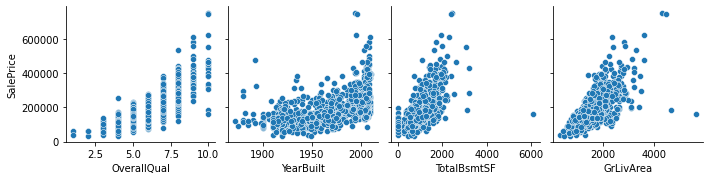

In [ ]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

###House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [ ]:
# Get column mean and std for normalization
df.describe()

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1971.267808,1057.429452,1515.463699,180921.195890
std,1.382997,30.202904,438.705324,525.480383,79442.502883
min,1.000000,1872.000000,0.000000,334.000000,34900.000000
25%,5.000000,1954.000000,795.750000,1129.500000,129975.000000
50%,6.000000,1973.000000,991.500000,1464.000000,163000.000000
75%,7.000000,2000.000000,1298.250000,1776.750000,214000.000000
max,10.000000,2010.000000,6110.000000,5642.000000,755000.000000


In [ ]:
df['OverallQual'] = (df['OverallQual'] - df['OverallQual'].mean()) / df['OverallQual'].std()
df['YearBuilt'] = (df['YearBuilt'] - df['YearBuilt'].mean()) / df['YearBuilt'].std()
df['TotalBsmtSF'] = (df['TotalBsmtSF'] - df['TotalBsmtSF'].mean()) / df['TotalBsmtSF'].std()
df['GrLivArea'] = (df['GrLivArea'] - df['GrLivArea'].mean()) / df['GrLivArea'].std()
df['SalePrice'] = (df['SalePrice'] - df['SalePrice'].mean()) / df['SalePrice'].std()

In [ ]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] # get the target values

In [ ]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

In [ ]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self, nb_layers=1, nb_neurons=4, activation=None):
        super(Model, self).__init__()
        
        self.module_list = nn.ModuleList()
        # Create nb_layers-1 linear layers
        for i in range(1,nb_layers):
          if i == 1:
            self.module_list.append(nn.Linear(4,nb_neurons))
          else:
            self.module_list.append(nn.Linear(nb_neurons,nb_neurons))
          # Add activations
          if activation == "sigmoid":
            self.module_list.append(nn.Sigmoid())
          elif activation == "tanh":
            self.module_list.append(nn.Tanh())
          elif activation == "relu":
            self.module_list.append(nn.ReLU())

        # Create final output layer
        if nb_layers == 1:
          self.module_list.append(nn.Linear(4,1))
        else:
          self.module_list.append(nn.Linear(nb_neurons,1))
        # No activation is added at the end just because targets are real valued and cannot be reduced to 0-1 or positives
        
    def forward(self, x):
        for layer in self.module_list:
          x = layer(x)
        return x

In [ ]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Define transformation (standardization)
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # create the dataset.

In [ ]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataloader, verbose=True):

    train_losses, validation_losses = [], []
    best_epoch, best_loss = 0, math.inf
    model_state_dict = None

    for epoch in range(num_epochs):
        epoch_average_loss = 0.0

        # Train
        model.train()
        for (X, y) in (dataloader):
            y_pre = model(X).view(-1)

            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

        train_losses.append(epoch_average_loss)
        
        # Validate
        model.eval()
        with torch.no_grad():
            y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
            error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
            validation_losses.append(error)

        if ((epoch+1)%1 == 0) and verbose:
                print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss, error))

        if validation_losses[-1] < best_loss:
            # New best model
            if verbose:
                print("Best Epoch!")
            best_epoch, best_loss = epoch, validation_losses[-1]
            # Save best model
            model_state_dict = model.state_dict()

    # Return to best model
    if not model_state_dict is None:
        model.load_state_dict(model_state_dict)
                
    return train_losses, validation_losses

In [ ]:
model = Model()
loader = DataLoader(train_set, 10, shuffle=True)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader)

Epoch [1/20], Train Loss: 0.7079, Validation Loss: 0.6119
Best Epoch!
Epoch [2/20], Train Loss: 0.4674, Validation Loss: 0.4513
Best Epoch!
Epoch [3/20], Train Loss: 0.3582, Validation Loss: 0.3743
Best Epoch!
Epoch [4/20], Train Loss: 0.3046, Validation Loss: 0.3331
Best Epoch!
Epoch [5/20], Train Loss: 0.2754, Validation Loss: 0.3094
Best Epoch!
Epoch [6/20], Train Loss: 0.2584, Validation Loss: 0.2948
Best Epoch!
Epoch [7/20], Train Loss: 0.2473, Validation Loss: 0.2846
Best Epoch!
Epoch [8/20], Train Loss: 0.2396, Validation Loss: 0.2769
Best Epoch!
Epoch [9/20], Train Loss: 0.2339, Validation Loss: 0.2712
Best Epoch!
Epoch [10/20], Train Loss: 0.2297, Validation Loss: 0.2670
Best Epoch!
Epoch [11/20], Train Loss: 0.2262, Validation Loss: 0.2639
Best Epoch!
Epoch [12/20], Train Loss: 0.2241, Validation Loss: 0.2614
Best Epoch!
Epoch [13/20], Train Loss: 0.2223, Validation Loss: 0.2592
Best Epoch!
Epoch [14/20], Train Loss: 0.2209, Validation Loss: 0.2577
Best Epoch!
Epoch [15/20], 

In [ ]:
model_state_dict

OrderedDict([('module_list.0.weight',
              tensor([[0.3261, 0.1738, 0.2366, 0.4290]])),
             ('module_list.0.bias', tensor([0.0115]))])

In [ ]:
model.state_dict()

OrderedDict([('module_list.0.weight',
              tensor([[0.3876, 0.1162, 0.2753, 0.3666]])),
             ('module_list.0.bias', tensor([0.0036]))])

####Evaluate the Model on the validation set

In [ ]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 0.2520599067211151


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

We decide to train models by changing one parameter at a time (number of layer, activation function and number of neurons). In order to select the best model, we would need to train for all combinations of parameters which is more time consuming.

In [ ]:
# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 10

### Number of Layers

In [ ]:
# We train models for the following number of layers:
nb_layers_list = [1,2,3,4,5,6]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for nb_layers in nb_layers_list:

  model = Model(nb_layers=nb_layers)

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  print("Training model for parameter:",nb_layers)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 1
Training model for parameter: 2
Training model for parameter: 3
Training model for parameter: 4
Training model for parameter: 5
Training model for parameter: 6


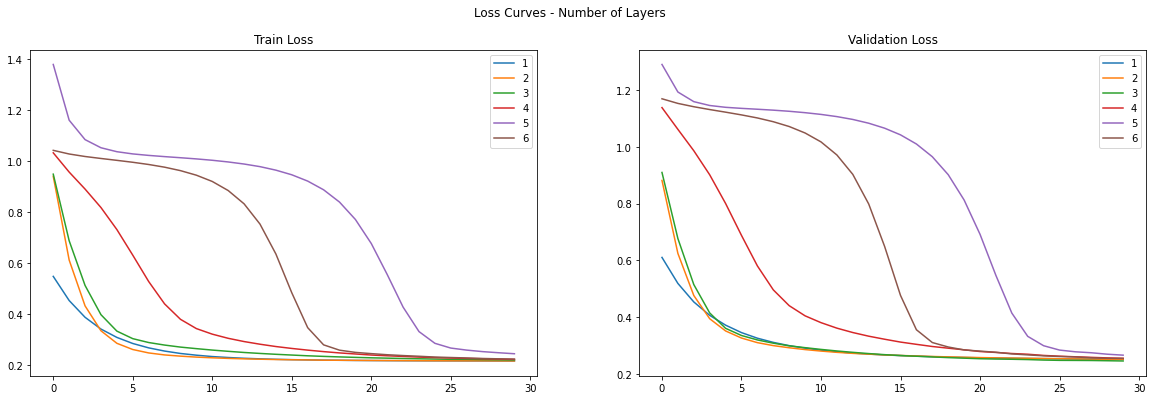

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Number of Layers")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=nb_layers_list[i])
  axs[1].plot(validation_losses[i,:], label=nb_layers_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

The 3 simplest models stand out from the rest. Moreover, models with 2 and 3 layers converge faster than the rest. We thus choose 2 layers in the future as it is the simplest of best models.

### Activation Functions

In [ ]:
# We train models for the following activation functions:
activation_fct_list = [None,"sigmoid","tanh","relu"]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for activation_fct in activation_fct_list:

  model = Model(nb_layers=2, activation=activation_fct)

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  print("Training model for parameter:",activation_fct)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: None
Training model for parameter: sigmoid
Training model for parameter: tanh
Training model for parameter: relu


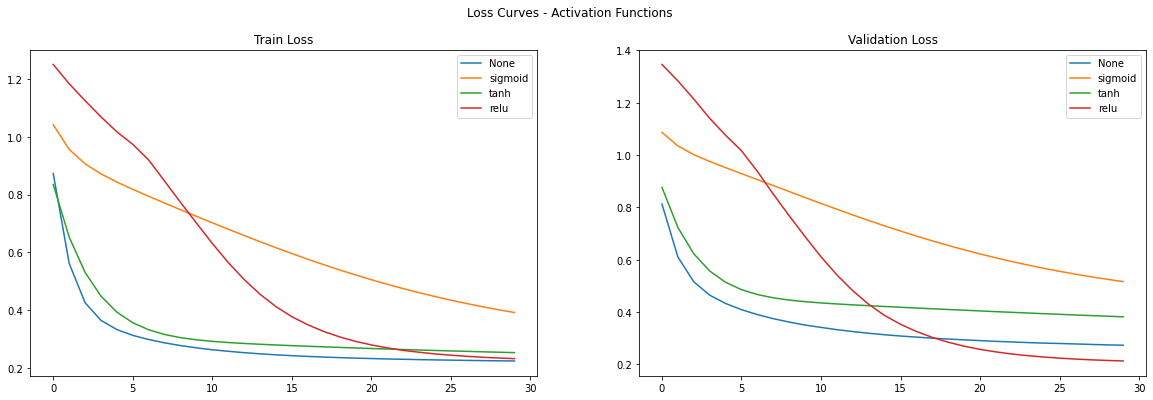

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Activation Functions")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label="None" if activation_fct_list[i] is None else activation_fct_list[i])
  axs[1].plot(validation_losses[i,:], label="None" if activation_fct_list[i] is None else activation_fct_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

The two best models are obtained from no activation and ReLU activation. Convergence is much faster when using no activation but performance on validation data is better when using ReLU activation. Because the model is quite fast to train, we use ReLU.

### Number of Neurons

In [ ]:
# We train models for the following number of neurons:
nb_neurons_list = [6,8,10,12,14,20]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for nb_neurons in nb_neurons_list:

  model = Model(nb_layers=2, activation="relu", nb_neurons=nb_neurons)

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  print("Training model for parameter:",nb_neurons)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 6
Training model for parameter: 8
Training model for parameter: 10
Training model for parameter: 12
Training model for parameter: 14
Training model for parameter: 20


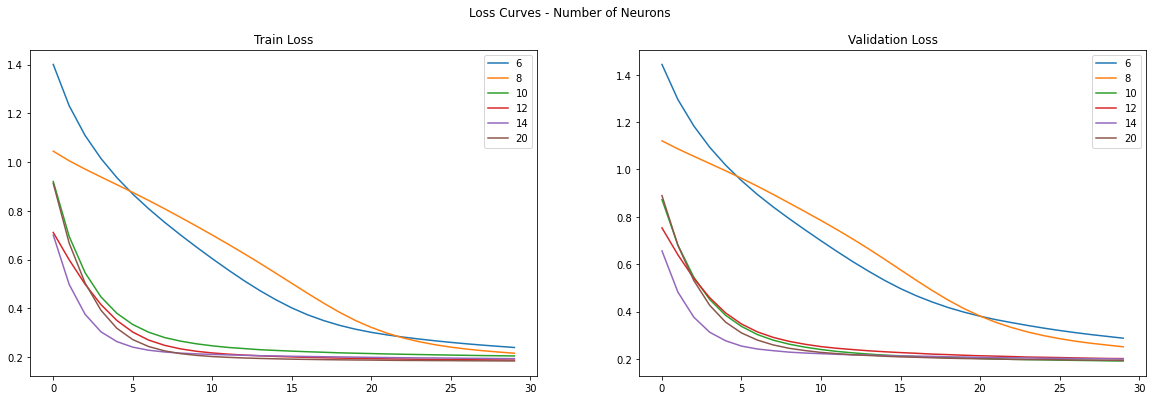

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Number of Neurons")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=nb_neurons_list[i])
  axs[1].plot(validation_losses[i,:], label=nb_neurons_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

We obtain a clear correlation between number of neurons and model performance. Indeed, it seems like the more neurons we use, the better our model is until a given threshold. Our best model contains 14 neurons per layer.

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

For this exercise, we use the model architecture obtained from Exercise 1. That is, a model with 2 layers of 14 neurons each and ReLU activation.

### Batch Sizes

In [ ]:
# We train models for the following batch sizes:
batch_size_list = [10,25,50,75,100,200,300,400]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes

for batch_size in batch_size_list:
  loader = DataLoader(train_set, batch_size, shuffle=True)

  model = Model(nb_layers=2, activation="relu", nb_neurons=14)

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  print("Training model for parameter:",batch_size)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 10
Training model for parameter: 25
Training model for parameter: 50
Training model for parameter: 75
Training model for parameter: 100
Training model for parameter: 200
Training model for parameter: 300
Training model for parameter: 400


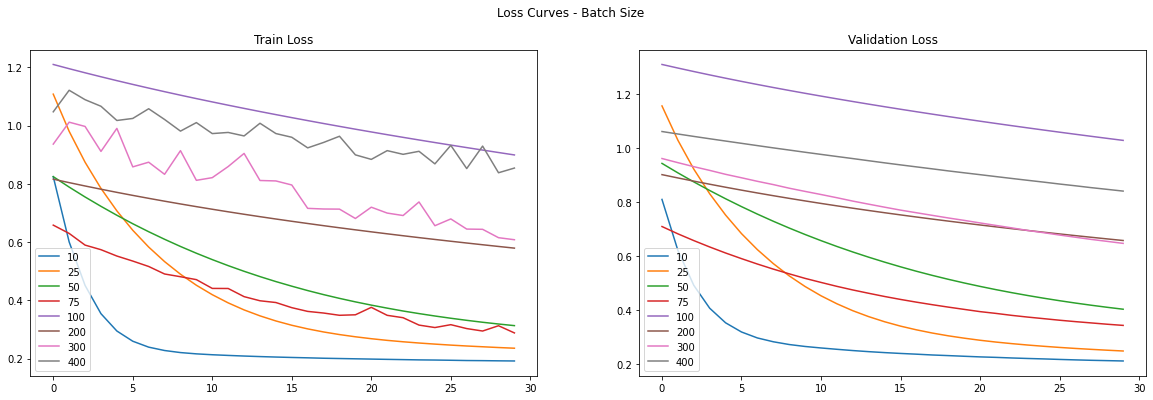

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Batch Size")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=batch_size_list[i])
  axs[1].plot(validation_losses[i,:], label=batch_size_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

It seems like there is a clear correlation between batch size and model performance. Indeed, the lower the batch size, the better the model. At least, training is much faster for lower values of batch sizes. We may obtain similar performances if we decided to train for a longer period but there is no point to do so. We thus keep our original batch size of 10.

In [ ]:
batch_size = 10

### Learning Rate

In [ ]:
# We train models for the following learning rates:
lr_list = [0.001, 0.01, 0.1, 1., 10.]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for lr in lr_list:

  model = Model(nb_layers=2, activation="relu", nb_neurons=14)

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  print("Training model for parameter:",lr)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 0.001
Training model for parameter: 0.01
Training model for parameter: 0.1
Training model for parameter: 1.0
Training model for parameter: 10.0


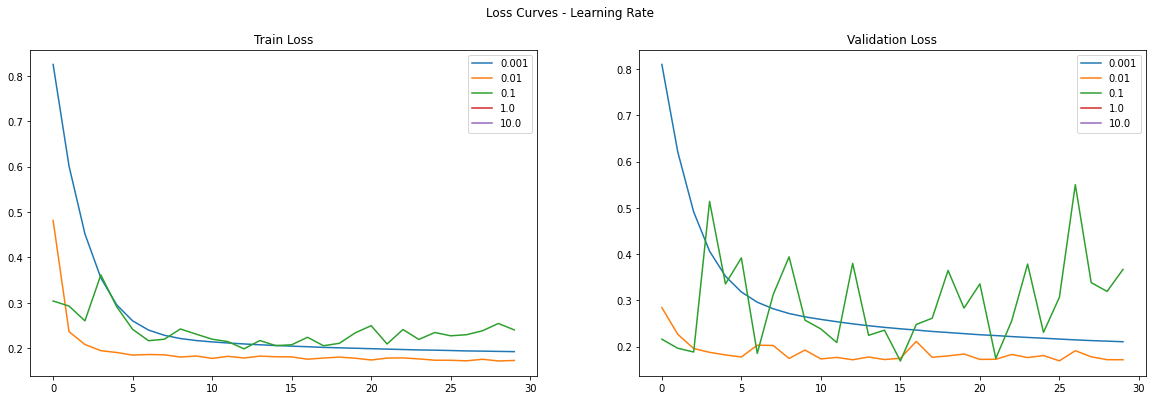

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Learning Rate")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=lr_list[i])
  axs[1].plot(validation_losses[i,:], label=lr_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

Model diverges for learning rates greater than 1. This is expected as it generates to great of steps in our Gradient Descent. If our loss function is irregular, this phenomenon will be observed. Let us retrain models for smaller learning rate values. 

In [ ]:
# We train models for the following learning rates:
lr_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for lr in lr_list:

  model = Model(nb_layers=2, activation="relu", nb_neurons=14)

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  print("Training model for parameter:",lr)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 0.001
Training model for parameter: 0.005
Training model for parameter: 0.01
Training model for parameter: 0.05
Training model for parameter: 0.1
Training model for parameter: 0.5


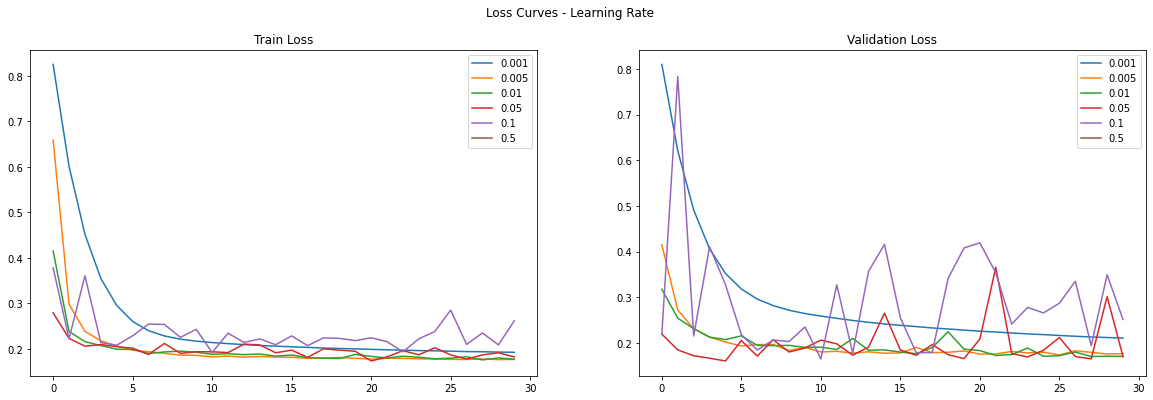

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Learning Rate")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=lr_list[i])
  axs[1].plot(validation_losses[i,:], label=lr_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

Best performances are obtained for models with learning rates between 0.005 and 0.1. We rule out the selection of learning rates greater than 0.05 because, for those values, training process fluctuates significantly. There is thus higher risk not to obtain satisfying results during training. Models with learning rates 0.005 and 0.01 are extremely similar. We chose lr=0.005 simply because training seems a bit smoother.

#### Model Architecture
Based on the values of batch size and learning rate selected, we decide to rework our model's architecture. We test several combinations of (number of layers, activation, number of neurons) and select the best one based on performance on validation data.

The combinations of parameters we decide to test upon are based on our observations from Exercise 1. That is, best models are obtained with 1 to 3 layers, no or ReLU activation and number of neurons between 10 and 14.

In [ ]:
# We train models for the following parameters:
param_list = [(1,None,10), (2,None,10), (3,None,10),
              (1,"relu",10), (2,"relu",10), (3,"relu",10),
              (1,None,14), (2,None,14), (3,None,14),
              (1,"relu",14), (2,"relu",14), (3,"relu",14)]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = Model(nb_layers=param[0], activation=param[1], nb_neurons=param[2])

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

  print("Training model for parameter:",param)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: (1, None, 10)
Training model for parameter: (2, None, 10)
Training model for parameter: (3, None, 10)
Training model for parameter: (1, 'relu', 10)
Training model for parameter: (2, 'relu', 10)
Training model for parameter: (3, 'relu', 10)
Training model for parameter: (1, None, 14)
Training model for parameter: (2, None, 14)
Training model for parameter: (3, None, 14)
Training model for parameter: (1, 'relu', 14)
Training model for parameter: (2, 'relu', 14)
Training model for parameter: (3, 'relu', 14)


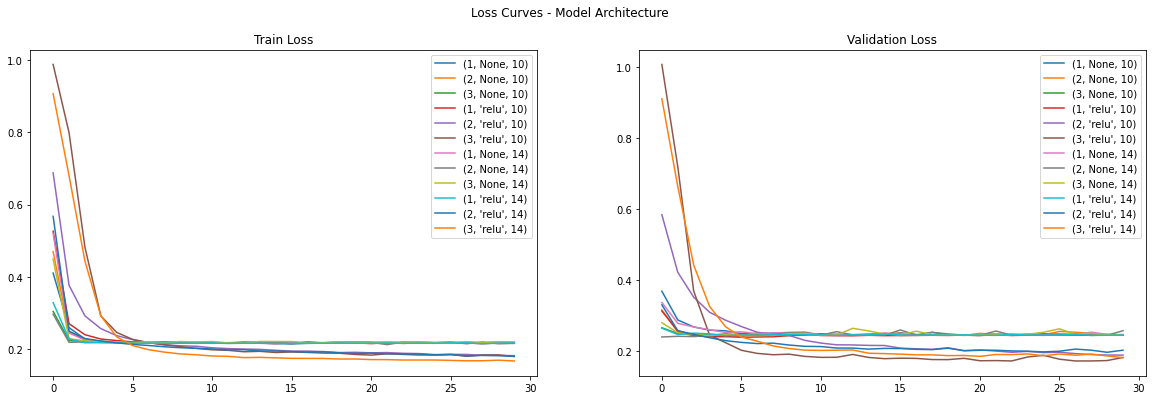

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Model Architecture")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

This shows how our model select in Exercise 1 was not correctly led. Indeed, choosing optimal parameters successively does not necessaarily produce the best combination of parameters. Model select should be done by directly comparing all combinations of parameters we aim to test.

Though several models obtain similar results, one model stands out from the rest: 3 layers, ReLU activation and 10 neurons per layer. Its training converges quite fast and offers the best performance on validation data.

### Epochs
In order to test for epochs, we train our model for a very large number of epochs. We will observe if this offers significant improvements on model performance and find the best compromise between training time and performance.

In [ ]:
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

model = Model(nb_layers=3, activation="relu", nb_neurons=10)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

large_num_epochs = 2000
train_loss, validation_loss = train(large_num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

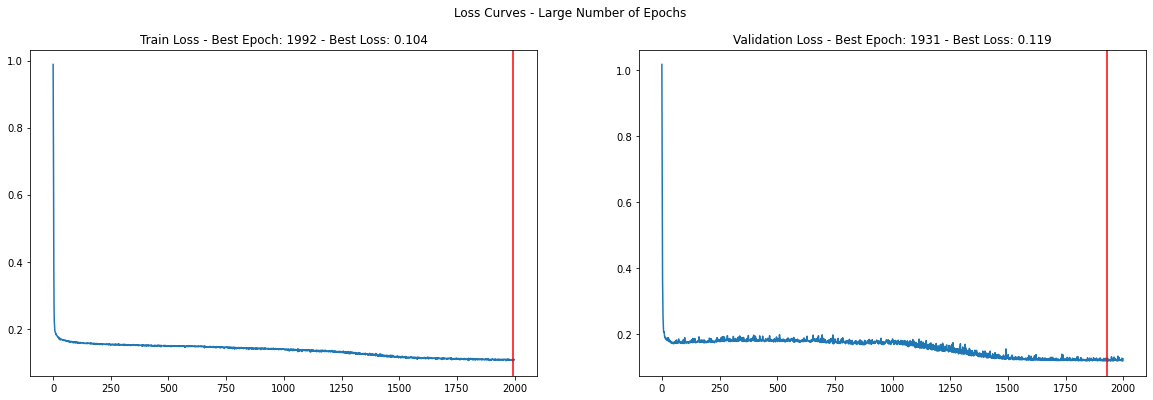

In [ ]:
# Compute best epoch
best_epoch_train, best_epoch_val = np.argmin(train_loss), np.argmin(validation_loss)
best_loss_train, best_loss_val = train_loss[best_epoch_train], validation_loss[best_epoch_val]

# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Large Number of Epochs")

axs[0].set_title("Train Loss - Best Epoch: {} - Best Loss: {}".format(best_epoch_train,int(best_loss_train*1000)/1000))
axs[1].set_title("Validation Loss - Best Epoch: {} - Best Loss: {}".format(best_epoch_val,int(best_loss_val*1000)/1000))
axs[0].plot(train_loss)
axs[0].axvline(x=best_epoch_train, c='r')
axs[1].plot(validation_loss)
axs[1].axvline(x=best_epoch_val, c='r')

fig.show()

This shows our model is able to improve over a large period of time. Though a plateau was reached after a short amount of epochs (around 30) and loss did not improve for the next 1000 periods, significant improvement is to notice in the following 1000 epochs. Therefore, choosing the correct number of epochs in this case is a matter of finding the best trade-off between performance and training time. We choose to train over 30 epochs, which allows to keep significantly low training time. Once we will have obtained our best model, we'll increase epochs significantly in order to obtain the best version of our best model.

### Optimizer

We aim to choose the best optimizer for our problem. To do so, we'll test several state of the art optimizers, using the best architecture and parameters for our model. Other hyper-parameters such as momentum are kept by default at first. Once we'll have chosen the best performing optimizer, we'll be able to select best hyper-parameters.

In [ ]:
# We train models for the following parameters:
optim_list = ["adagrad","adam","adamax","rmsprop","sgd"]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for optim in optim_list:

  model = Model(nb_layers=3, activation="relu", nb_neurons=10)

  criterion = nn.MSELoss()
  if optim == "adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.005)
  elif optim == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
  elif optim == "adamax":
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.005)
  elif optim == "rmsprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
  elif optim == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

  print("Training model for parameter:",optim)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: adagrad
Training model for parameter: adam
Training model for parameter: adamax
Training model for parameter: rmsprop
Training model for parameter: sgd


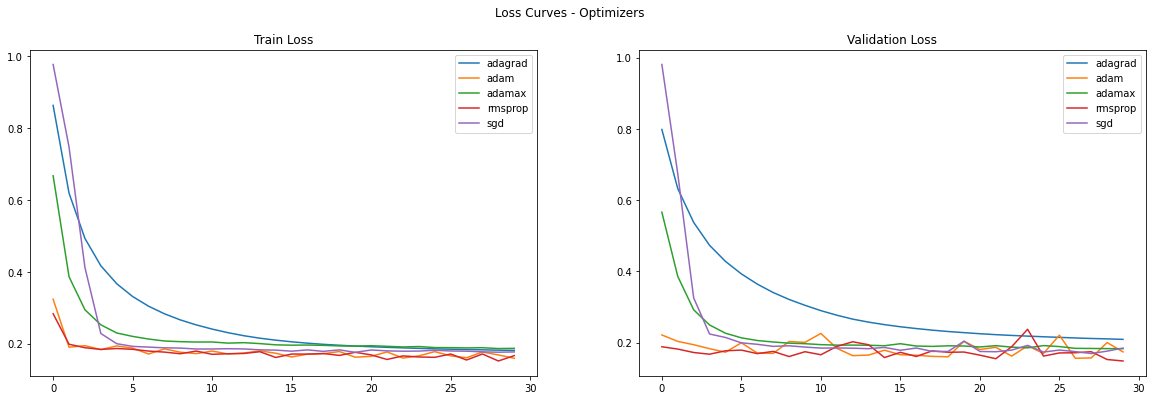

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Optimizers")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=optim_list[i])
  axs[1].plot(validation_losses[i,:], label=optim_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

As expected, more complex optimization methods offer faster convergence than Stochastic Gradient Descent. In fact, RMSProp and Adam have almost immediate convergence and better performance but are quite noisy. Adamax and SGD and quite comparable both in terms of performance and convergence. Adagrad seems slower and less performing than the rest of the optimizers.

We aim to tune both optimizers (Adam and RMSProp) with regards to their hyper-parameters. $\beta_1, \beta_2,\epsilon$ for Adam and $ϵ$. Note we could try to optimize more parameters for these optimizers, but these are the classically optimized ones.

In [ ]:
# Adam
# List all combinations of parameters in the following format: (epsilon,beta_1,beta_2)
param_list = [(1e-8,0.9,0.99),(1e-6,0.9,0.99),
              (1e-8,0.99,0.99),(1e-6,0.99,0.99),
              (1e-8,0.9,0.999),(1e-6,0.9,0.999),
              (1e-8,0.99,0.999),(1e-6,0.99,0.999)]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = Model(nb_layers=3, activation="relu", nb_neurons=10)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(param[1],param[2]), eps=param[0])

  print("Training model for parameter:",param)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: (1e-08, 0.9, 0.99)
Training model for parameter: (1e-06, 0.9, 0.99)
Training model for parameter: (1e-08, 0.99, 0.99)
Training model for parameter: (1e-06, 0.99, 0.99)
Training model for parameter: (1e-08, 0.9, 0.999)
Training model for parameter: (1e-06, 0.9, 0.999)
Training model for parameter: (1e-08, 0.99, 0.999)
Training model for parameter: (1e-06, 0.99, 0.999)


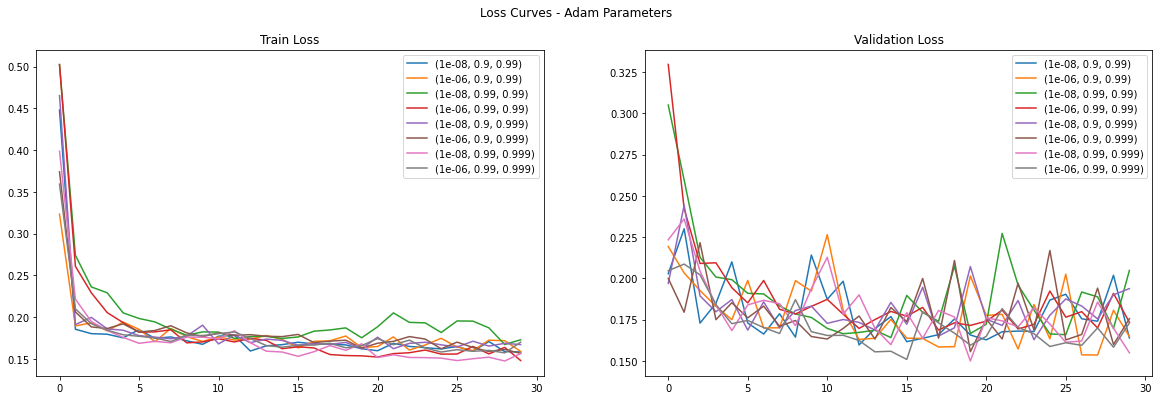

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Adam Parameters")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

In [ ]:
# Adam
# List all combinations of parameters in the following format: (epsilon,beta_1,beta_2)
param_list = [1e-10,1e-9,1e-8,1e-6,1e-4,1e-2,1e-1]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = Model(nb_layers=3, activation="relu", nb_neurons=10)

  criterion = nn.MSELoss()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, eps=param)

  print("Training model for parameter:",param)
  train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 1e-10
Training model for parameter: 1e-09
Training model for parameter: 1e-08
Training model for parameter: 1e-06
Training model for parameter: 0.0001
Training model for parameter: 0.01
Training model for parameter: 0.1


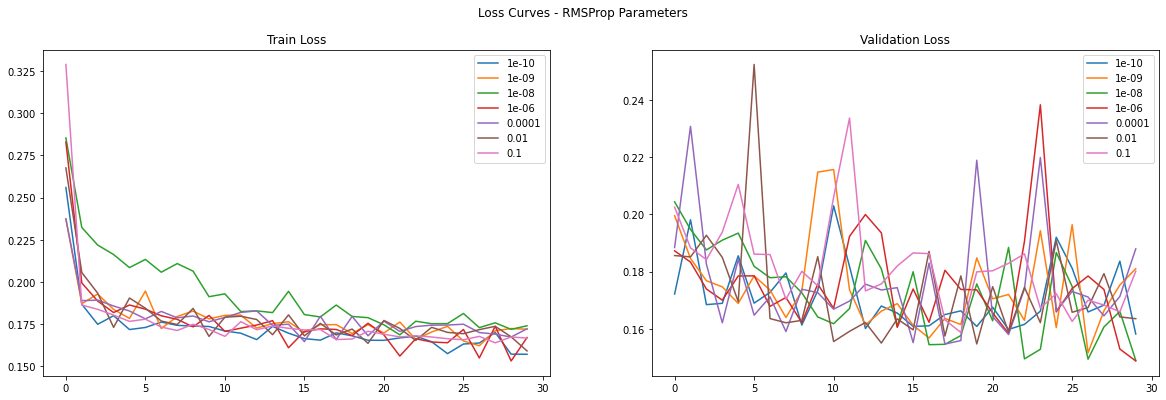

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - RMSProp Parameters")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

The first observation is that it is extremely complicated to differentiate between performances of the same optimizer with the different parameters we have tested. Indeed, training with these optimizers creates high fluctuations and it is impossible to extract the best set of parameters. What we can observe is that Adam offers better results on validation data and thus should be chosen over RMSProp. As no set of parameters stands out, we decide to keep the default ones, which are also suggested in the original paper for Adam.

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


First we define our custom loss function.

In [ ]:
class NGaussianLikelihood(nn.Module):
    def __init__(self):
        super(NGaussianLikelihood, self).__init__()

    def forward(self, inputs, targets):
        gauss_lklh = torch.log(2*math.pi*torch.square(torch.squeeze(inputs[:,1]))) + torch.square(targets - torch.squeeze(inputs[:,0])) / (2*torch.square(torch.squeeze(inputs[:,1])))
        return torch.mean(gauss_lklh)

We then implement an adapted model that outputs two values: the mean and std of our Gaussian distributions.

In [ ]:
# Construct a model with one layer
class ModelGL(nn.Module):
    
    def __init__(self, nb_layers=1, nb_neurons=4, activation=None):
        super(ModelGL, self).__init__()
        
        self.module_list = nn.ModuleList()
        # Create nb_layers-1 linear layers
        for i in range(1,nb_layers):
          if i == 1:
            self.module_list.append(nn.Linear(4,nb_neurons))
          else:
            self.module_list.append(nn.Linear(nb_neurons,nb_neurons))
          # Add activations
          if activation == "sigmoid":
            self.module_list.append(nn.Sigmoid())
          elif activation == "tanh":
            self.module_list.append(nn.Tanh())
          elif activation == "relu":
            self.module_list.append(nn.ReLU())

        # Create final output layer
        if nb_layers == 1:
          self.module_list.append(nn.Linear(4,2))
        else:
          self.module_list.append(nn.Linear(nb_neurons,2))
        # No activation is added at the end just because targets are real valued and cannot be reduced to 0-1 or positives
        
    def forward(self, x):
        for layer in self.module_list:
          x = layer(x)
        return x

We can then train our model using the parameters chosen in Exercises 1 & 2 using our new loss function.

In [ ]:
def trainGL(num_epochs, batch_size, criterion, optimizer, model, dataloader, verbose=True):

    train_losses, validation_losses = [], []
    best_epoch, best_loss = 0, math.inf
    model_state_dict = None

    for epoch in range(num_epochs):
        epoch_average_loss = 0.0

        # Train
        model.train()
        for (X, y) in (dataloader):
            y_pre = model(X)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)

        train_losses.append(epoch_average_loss)
        
        # Validate
        model.eval()
        with torch.no_grad():
          y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
          error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
          validation_losses.append(error)

        if ((epoch+1)%1 == 0) and verbose:
                print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss, error))
        
        if validation_losses[-1] < best_loss:
          # New best model
          if verbose:
            print("Best Epoch!")
          best_epoch, best_loss = epoch, validation_losses[-1]
          # Save best model
          model_state_dict = model.state_dict()

    # Return to best model
    if not model_state_dict is None:
        model.load_state_dict(model_state_dict)
                
    return train_losses, validation_losses

In [ ]:
# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

model = ModelGL(nb_layers=3, activation="relu", nb_neurons=10)

criterion = NGaussianLikelihood()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=True)

Epoch [1/30], Train Loss: 2.1931, Validation Loss: 1.2776
Best Epoch!
Epoch [2/30], Train Loss: 0.6772, Validation Loss: 0.2629
Best Epoch!
Epoch [3/30], Train Loss: 0.5976, Validation Loss: 0.3572
Epoch [4/30], Train Loss: 0.0389, Validation Loss: 0.1855
Best Epoch!
Epoch [5/30], Train Loss: 0.3182, Validation Loss: 0.5727
Epoch [6/30], Train Loss: 0.3875, Validation Loss: 0.1016
Best Epoch!
Epoch [7/30], Train Loss: -0.0145, Validation Loss: -0.0184
Best Epoch!
Epoch [8/30], Train Loss: -0.1263, Validation Loss: -0.0903
Best Epoch!
Epoch [9/30], Train Loss: 0.6488, Validation Loss: 0.8465
Epoch [10/30], Train Loss: 0.6999, Validation Loss: 0.6477
Epoch [11/30], Train Loss: 0.4848, Validation Loss: 0.4025
Epoch [12/30], Train Loss: 0.3119, Validation Loss: 0.1639
Epoch [13/30], Train Loss: -0.0656, Validation Loss: 0.0020
Epoch [14/30], Train Loss: -0.1692, Validation Loss: -0.0678
Epoch [15/30], Train Loss: -0.2097, Validation Loss: -0.0144
Epoch [16/30], Train Loss: -0.1647, Validat

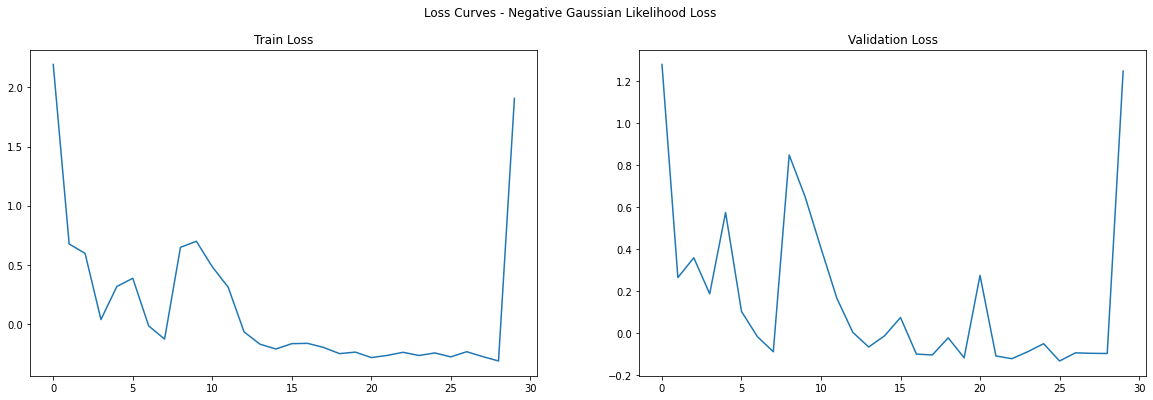

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Negative Gaussian Likelihood Loss")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
axs[0].plot(train_loss)
axs[1].plot(validation_loss)

fig.show()

We obtain satisfying training curves, though they aren't as smooth as for the mean squared error loss. This is expected due to the higher complexity of the loss function we are using. In particular, loss increases significantly at the last epoch. This suggests we should implement a best model checkpoint where, at the end of training, model weights are updated to the ones from best performing model. Let us tune our model's architecture before comparing results with previous model.

### Model Architecture

We are going to test several configurations for our model. We will attempt to compare shallow and deep models, test ReLU activation and no activation (we observed they worked best) and low and high number of neurons.

In [ ]:
# We train models for the following parameters:
nb_layers_list = [2] # We test for deep networks as it is suggested above
activation_fct_list = [None,"relu"]
nb_neurons_list = [4,10,20]
param_list = [(nb_layers,activation,nb_neurons) for nb_layers in nb_layers_list for activation in activation_fct_list for nb_neurons in nb_neurons_list]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = ModelGL(nb_layers=param[0], activation=param[1], nb_neurons=param[2])

  criterion = NGaussianLikelihood()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  print("Training model for parameter:",param)
  train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: (2, None, 4)
Training model for parameter: (2, None, 10)
Training model for parameter: (2, None, 20)
Training model for parameter: (2, 'relu', 4)
Training model for parameter: (2, 'relu', 10)
Training model for parameter: (2, 'relu', 20)


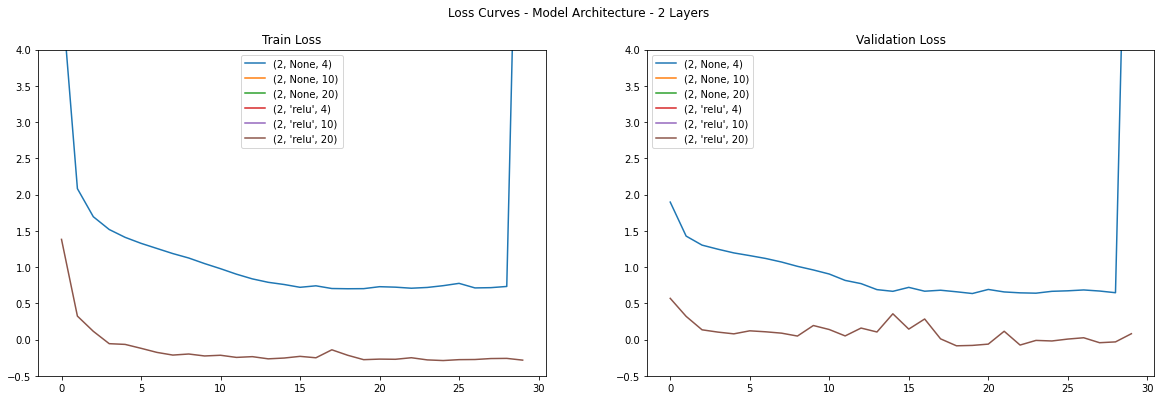

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Model Architecture - 2 Layers")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-.5,4)
axs[1].set_ylim(-.5,4)

fig.show()

In [ ]:
# We train models for the following parameters:
nb_layers_list = [10] # We test for deep networks as it is suggested above
activation_fct_list = [None,"relu"]
nb_neurons_list = [4,10,20]
param_list = [(nb_layers,activation,nb_neurons) for nb_layers in nb_layers_list for activation in activation_fct_list for nb_neurons in nb_neurons_list]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = ModelGL(nb_layers=param[0], activation=param[1], nb_neurons=param[2])

  criterion = NGaussianLikelihood()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  print("Training model for parameter:",param)
  train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: (10, None, 4)
Training model for parameter: (10, None, 10)
Training model for parameter: (10, None, 20)
Training model for parameter: (10, 'relu', 4)
Training model for parameter: (10, 'relu', 10)
Training model for parameter: (10, 'relu', 20)


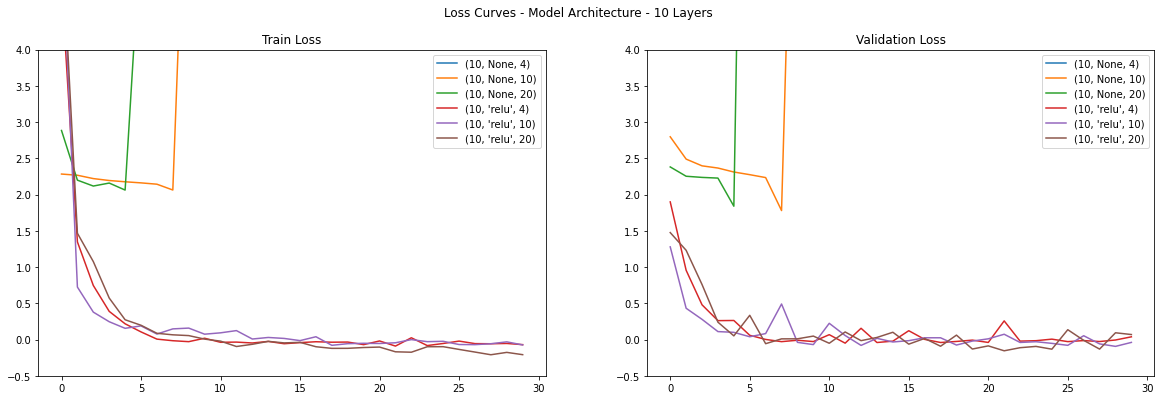

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Model Architecture - 10 Layers")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-.5,4)
axs[1].set_ylim(-.5,4)

fig.show()

In [ ]:
# We train models for the following parameters:
nb_layers_list = [20] # We test for deep networks as it is suggested above
activation_fct_list = [None,"relu"]
nb_neurons_list = [4,10,20]
param_list = [(nb_layers,activation,nb_neurons) for nb_layers in nb_layers_list for activation in activation_fct_list for nb_neurons in nb_neurons_list]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = ModelGL(nb_layers=param[0], activation=param[1], nb_neurons=param[2])

  criterion = NGaussianLikelihood()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  print("Training model for parameter:",param)
  train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: (20, None, 4)
Training model for parameter: (20, None, 10)
Training model for parameter: (20, None, 20)
Training model for parameter: (20, 'relu', 4)
Training model for parameter: (20, 'relu', 10)
Training model for parameter: (20, 'relu', 20)


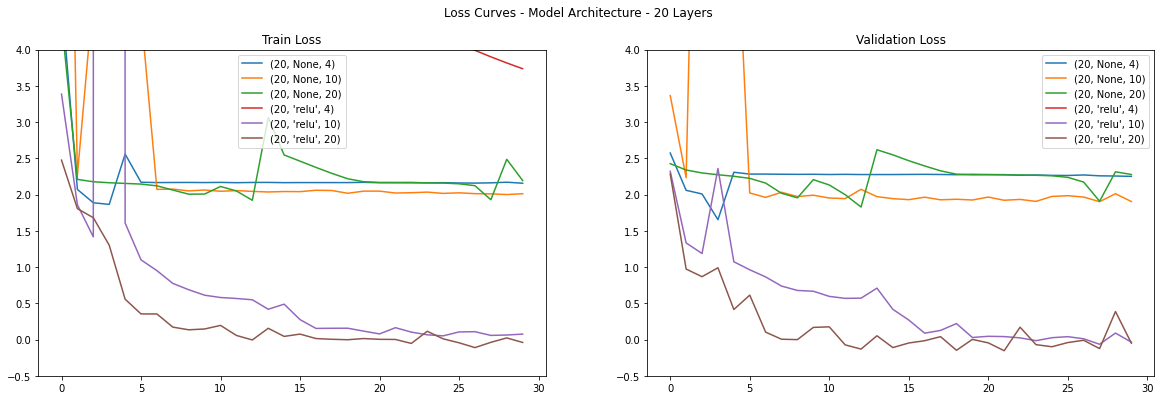

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Model Architecture - 20 Layers")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-.5,4)
axs[1].set_ylim(-.5,4)

fig.show()

We can infer two important results from these observations: deep (high number of layers) and dense (high number of neurons) models work better than shallow and light ones; ReLU activation must be applied. In fact, if both conditions are not met, loss tends to diverge during training. Therefore, we will compare deep and dense models and choose our final model's architecture.

In [ ]:
# We train models for the following parameters:
nb_layers_list = [10,15,20] # We test for deep networks as it is suggested above
activation_fct_list = ["relu"]
nb_neurons_list = [10,15,20]
param_list = [(nb_layers,activation,nb_neurons) for nb_layers in nb_layers_list for activation in activation_fct_list for nb_neurons in nb_neurons_list]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for param in param_list:

  model = ModelGL(nb_layers=param[0], activation=param[1], nb_neurons=param[2])

  criterion = NGaussianLikelihood()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

  print("Training model for parameter:",param)
  train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: (10, 'relu', 10)
Training model for parameter: (10, 'relu', 15)
Training model for parameter: (10, 'relu', 20)
Training model for parameter: (15, 'relu', 10)
Training model for parameter: (15, 'relu', 15)
Training model for parameter: (15, 'relu', 20)
Training model for parameter: (20, 'relu', 10)
Training model for parameter: (20, 'relu', 15)
Training model for parameter: (20, 'relu', 20)


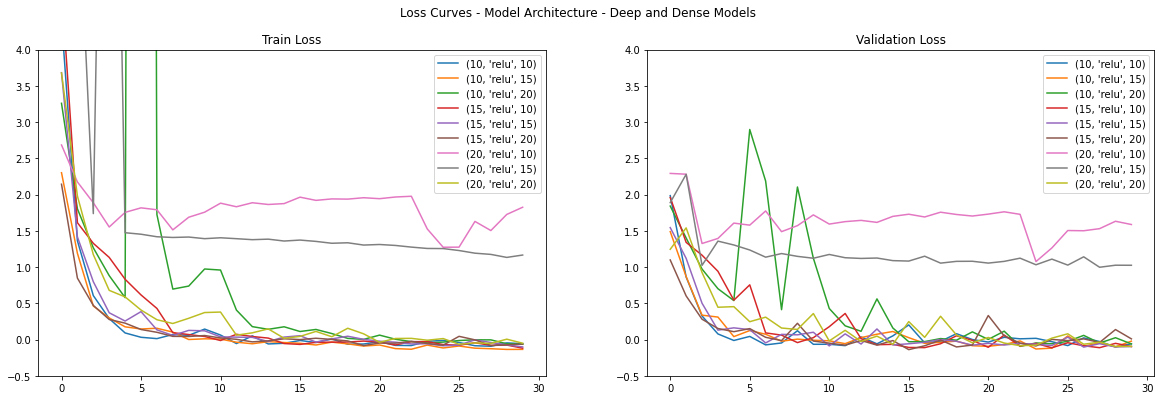

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Model Architecture - Deep and Dense Models")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=param_list[i])
  axs[1].plot(validation_losses[i,:], label=param_list[i])
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-.5,4)
axs[1].set_ylim(-.5,4)

fig.show()

First observation is that models with 20 layers do not train correctly. Second, most other models have similar behaviour and are difficult to compare. When in this situation, we opt for the simplest model. Thus, we choose a model architecture with 10 layers, ReLU activation and 10 neurons per layer.

Let us tune two main parameters of training: learning rate and batch size.

### Learning Rate

In [ ]:
# We train models for the following parameters:
lr_list = [0.0001,0.001,0.005,0.01,0.05,0.1,1.]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

for lr in lr_list:

  model = ModelGL(nb_layers=10, activation="relu", nb_neurons=10)

  criterion = NGaussianLikelihood()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  print("Training model for parameter:",lr)
  train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 0.0001
Training model for parameter: 0.001
Training model for parameter: 0.005
Training model for parameter: 0.01
Training model for parameter: 0.05
Training model for parameter: 0.1
Training model for parameter: 1.0


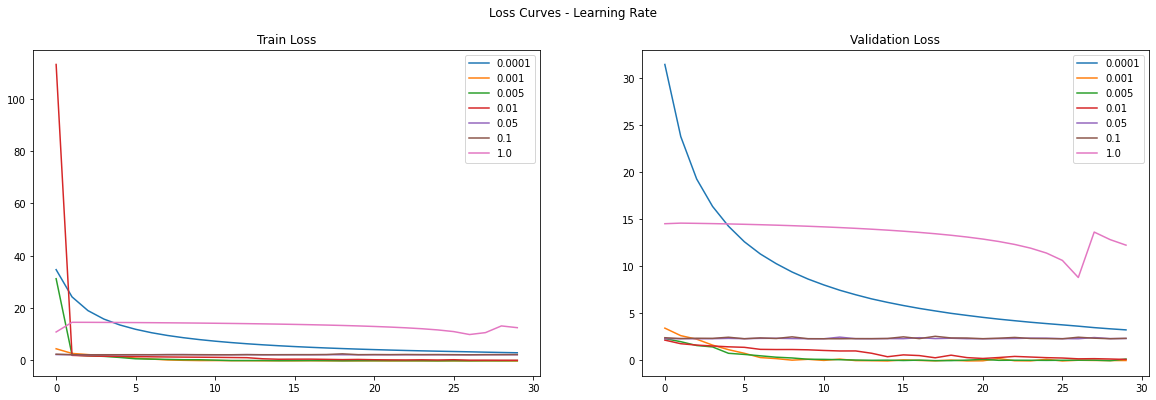

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Learning Rate")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=lr_list[i])
  axs[1].plot(validation_losses[i,:], label=lr_list[i])
axs[0].legend()
axs[1].legend()

fig.show()

Best results are obtained for learning rate 0.001 or 0.005, we choose to keep 0.001 as it is the default value with Adam optimization.

### Batch Size

In [ ]:
# We train models for the following parameters:
batch_size_list = [5,10,25,50,75,100,200,400]

# Train loop
train_losses, validation_losses = [],[]

# Batches must be the same for all models
torch.manual_seed(12345) # Set random seed for reproducibility purposes

for batch_size in batch_size_list:

  loader = DataLoader(train_set, batch_size, shuffle=True)
  model = ModelGL(nb_layers=10, activation="relu", nb_neurons=10)

  criterion = NGaussianLikelihood()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  print("Training model for parameter:",batch_size)
  train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

  train_losses.append(np.array(train_loss))
  validation_losses.append(validation_loss)

train_losses, validation_losses = np.array(train_losses), np.array(validation_losses)

Training model for parameter: 5
Training model for parameter: 10
Training model for parameter: 25
Training model for parameter: 50
Training model for parameter: 75
Training model for parameter: 100
Training model for parameter: 200
Training model for parameter: 400


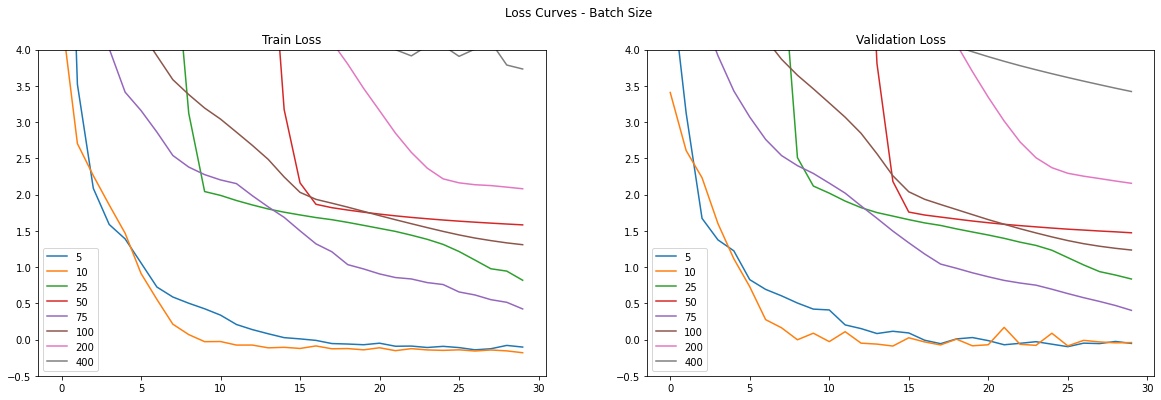

In [ ]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Batch Size")

axs[0].set_title("Train Loss")
axs[1].set_title("Validation Loss")
for i in range(train_losses.shape[0]):
  axs[0].plot(train_losses[i,:], label=batch_size_list[i])
  axs[1].plot(validation_losses[i,:], label=batch_size_list[i])
axs[0].legend()
axs[1].legend()
axs[0].set_ylim(-.5,4)
axs[1].set_ylim(-.5,4)

fig.show()

Training works equally well for batches of size 5 and 10. We choose to keep 10 as it is the value we have been using since the start and have used for Exercises 1 & 2.

In [ ]:
batch_size = 10

### Selecting Best Model

We now aim to compare the models obtained from Exercises 1 & 2 and Exercise 3. This is a complicated task as it should require to determine unbiased comparison criteria. On one hand, using RMSE to compare both models seems biased because model 1 was trained to minimize this metric. On the other hand, using Negative Gaussian Likelihood also seems biased because model 2 was trained to minimize this metric. 

We will compare both models using both metrics. For the RMSE, we will consider that the prediction of model 2 corresponds to the value $\mu_i$ and omit the standard deviation output. For the Negative Gaussian Likelihood, it is stated that minimizing the Mean Squared Error is equivalent to minimizing the Negative Gaussian Likelihood and setting standard deviation values to 1. Therefore, we will use predictions of model 1 as $\mu_i$ values and set $\sigma_i$ values to 1.

We first need to retrain our models on a larger number of epochs. As observed in Exercise 1, this will significantly improve our models' performances.

In [ ]:
num_epochs = 1500

In [ ]:
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

model = Model(nb_layers=3, activation="relu", nb_neurons=10)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_loss, validation_loss = train(num_epochs, batch_size, criterion, optimizer, model, loader, verbose=False)

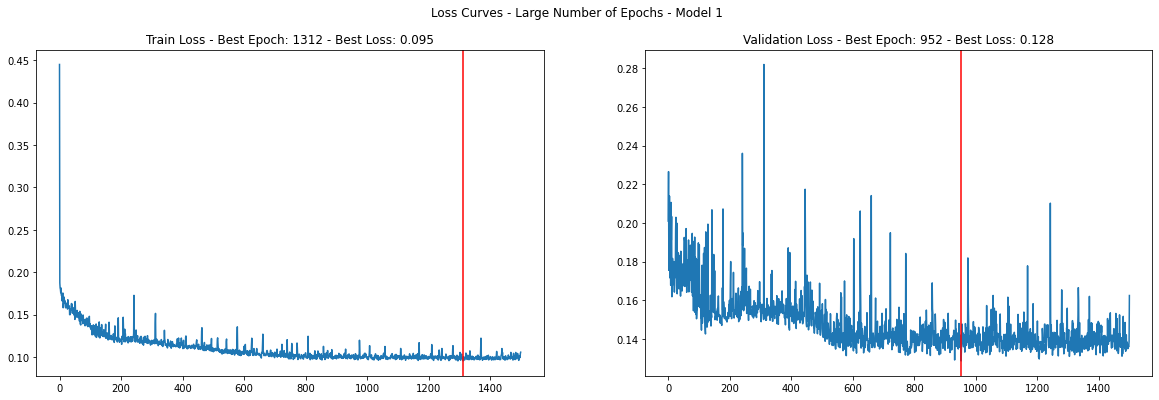

In [ ]:
# Compute best epoch
best_epoch_train, best_epoch_val = np.argmin(train_loss), np.argmin(validation_loss)
best_loss_train, best_loss_val = train_loss[best_epoch_train], validation_loss[best_epoch_val]

# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Large Number of Epochs - Model 1")

axs[0].set_title("Train Loss - Best Epoch: {} - Best Loss: {}".format(best_epoch_train,int(best_loss_train*1000)/1000))
axs[1].set_title("Validation Loss - Best Epoch: {} - Best Loss: {}".format(best_epoch_val,int(best_loss_val*1000)/1000))
axs[0].plot(train_loss)
axs[0].axvline(x=best_epoch_train, c='r')
axs[1].plot(validation_loss)
axs[1].axvline(x=best_epoch_val, c='r')

fig.show()

In [ ]:
# First we train both of our best models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

modelGL = ModelGL(nb_layers=10, activation="relu", nb_neurons=10)

criterion = NGaussianLikelihood()
optimizer = torch.optim.Adam(modelGL.parameters(), lr=0.001)

train_loss, validation_loss = trainGL(num_epochs, batch_size, criterion, optimizer, modelGL, loader, verbose=False)

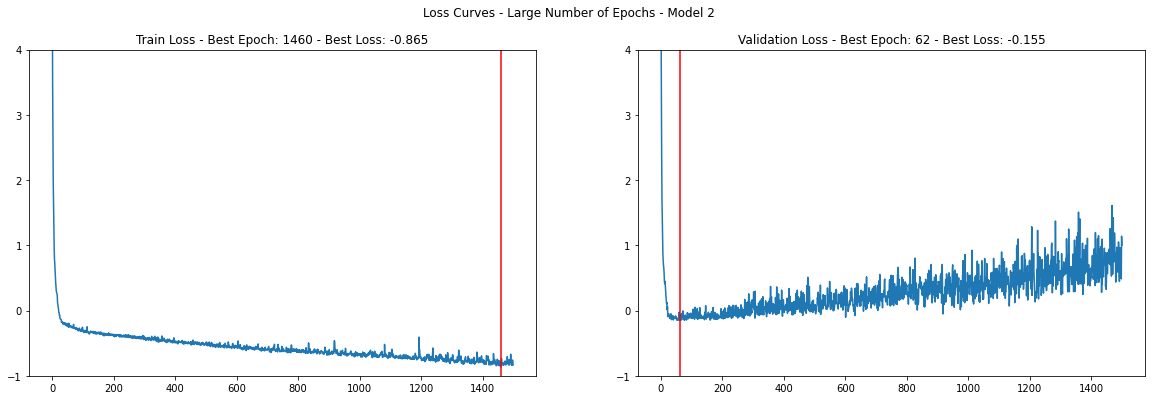

In [ ]:
# Compute best epoch
best_epoch_train, best_epoch_val = np.argmin(train_loss), np.argmin(validation_loss)
best_loss_train, best_loss_val = train_loss[best_epoch_train], validation_loss[best_epoch_val]

# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,6))

fig.suptitle("Loss Curves - Large Number of Epochs - Model 2")

axs[0].set_title("Train Loss - Best Epoch: {} - Best Loss: {}".format(best_epoch_train,int(best_loss_train*1000)/1000))
axs[1].set_title("Validation Loss - Best Epoch: {} - Best Loss: {}".format(best_epoch_val,int(best_loss_val*1000)/1000))
axs[0].plot(train_loss)
axs[0].axvline(x=best_epoch_train, c='r')
axs[1].plot(validation_loss)
axs[1].axvline(x=best_epoch_val, c='r')
axs[0].set_ylim(-1.,4)
axs[1].set_ylim(-1.,4)

fig.show()

Unfortunately, we are unable to make a best model checkpoint work. That is, after training to reset model to the state where it performed best. We are thus going to retrain both models the exact number of epochs to reach their best performance.

In [ ]:
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

model = Model(nb_layers=3, activation="relu", nb_neurons=10)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_loss, validation_loss = train(953, batch_size, criterion, optimizer, model, loader, verbose=False)

In [ ]:
# First we train both of our best models
torch.manual_seed(12345) # Set random seed for reproducibility purposes
loader = DataLoader(train_set, 10, shuffle=True)

modelGL = ModelGL(nb_layers=10, activation="relu", nb_neurons=10)

criterion = NGaussianLikelihood()
optimizer = torch.optim.Adam(modelGL.parameters(), lr=0.001)

train_loss, validation_loss = trainGL(63, batch_size, criterion, optimizer, modelGL, loader, verbose=False)

Let's compare MSE performance on validation data:

In [ ]:
criterion = nn.MSELoss()

In [ ]:
# MSE for model 1
model.eval()
with torch.no_grad():
  y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
  error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print("Model 1 MSE:",error)

# MSE for model 2
modelGL.eval()
with torch.no_grad():
  y_pre_val = modelGL(torch.from_numpy(np.array(X_val)).float())[:,0].view(-1)
  error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print("Model 2 MSE:",error)

Model 1 MSE: 0.1285935640335083
Model 2 MSE: 0.1729152351617813


Let's compare Negative Gaussian Likelihood on validation data:

In [ ]:
criterion = NGaussianLikelihood()

In [ ]:
# NGL for model 1
with torch.no_grad():
  y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
  y_pre_val = torch.cat([torch.unsqueeze(y_pre_val,dim=1),torch.ones(y_pre_val.shape[0],1)], dim=1) # Add ones in place of standard deviations
  error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print("Model 1 NGL:",error)

# NGL for model 2
with torch.no_grad():
  y_pre_val = modelGL(torch.from_numpy(np.array(X_val)).float())
  error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print("Model 2 NGL:",error)

Model 1 NGL: 1.9021737575531006
Model 2 NGL: -0.15529513359069824


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.

### Final Model Performance

Let us compute MSE and NGL of our best model on test data.

In [ ]:
# MSE for best model
criterion = nn.MSELoss()
with torch.no_grad():
  y_pre_test = modelGL(torch.from_numpy(np.array(X_test)).float())[:,0].view(-1)
  error = criterion(y_pre_test, torch.tensor(np.array(y_test)).float()).item()
print("Best Model Test MSE:",error)

# NGL for best model
criterion = NGaussianLikelihood()
with torch.no_grad():
  y_pre_test = modelGL(torch.from_numpy(np.array(X_test)).float())
  error = criterion(y_pre_test, torch.tensor(np.array(y_test)).float()).item()
print("Best Model Test NGL:",error)

Best Model Test MSE: 0.4707089960575104
Best Model Test NGL: -0.005859574768692255


Though our model generalizes satisfyingly well with regards to negative Gaussian Likelihood, it shows extremely poor results on Mean Squared Error (0.47). In the following section, we aim to prove whether this lack of precision in predicting the exact value $\mu$ is compensated by the prediction of a confidence value $\sigma$. 

### Correlation between Model Confidence and Feature Values

As our best model gives each prediction as a Gaussian probability rather than a unique value, it also predicts its confidence in the prediction it is making. Indeed, if model outputs $p(.|x_i)\sim\mathcal{N}(\mu_i,\sigma_i)$, the expected value of our prediction is $\hat{y_i} = E[p(.|x_i)]=\mu_i$ and $\sigma_i$ is a confidence indicator of this prediction. 

We attempt to find correlations between feature values and model confidence, let us thus plot $\sigma_i$ values with regards to the corresponding features.

First we make our predictions on test data.

In [ ]:
with torch.no_grad():
  y_pre_test = modelGL(torch.from_numpy(np.array(X_test)).float())
confidence = np.absolute(y_pre_test[:,1].numpy())
print(confidence.shape)

(260,)


In [ ]:
print(X_test.shape)

(260, 4)


#### OverallQual

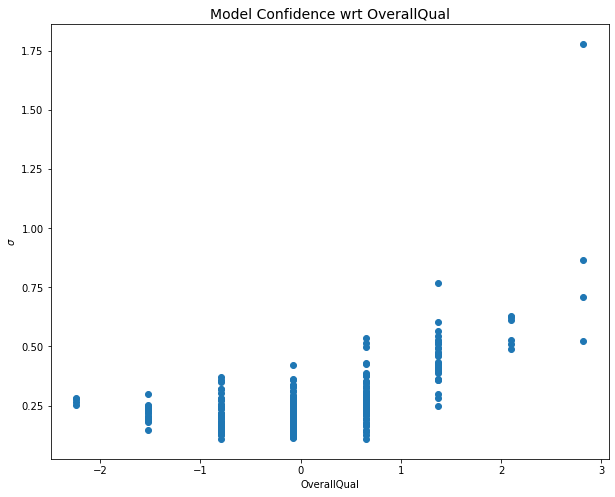

In [ ]:
# Plot model confidence wrt OverallQual
features = np.array(X_test["OverallQual"])

plt.figure(figsize=(10,8))
plt.title("Model Confidence wrt OverallQual", fontsize=14)
plt.scatter(features, confidence)
plt.xlabel("OverallQual")
plt.ylabel("$\sigma$")
plt.show()

There is no obvious linear correlation between OverallQual value and confidence. If anything, we could assert that model confidence becomes poor when OverallQual is high. This seems reasonnable as this feature takes discrete values and there are few data for high values of OverallQual. Necessarily, with low amounts of training data, predictions are less precise. In fact, model seems to have higher confidence in the OverallQual values where there are more data.

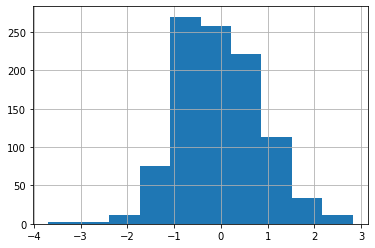

In [ ]:
X_train["OverallQual"].hist(bins=10)
plt.show()

#### YearBuilt

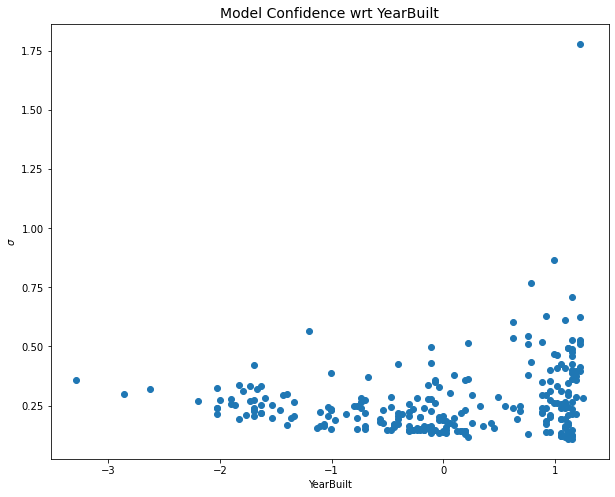

In [ ]:
# Plot model confidence wrt OverallQual
features = np.array(X_test["YearBuilt"])

plt.figure(figsize=(10,8))
plt.title("Model Confidence wrt YearBuilt", fontsize=14)
plt.scatter(features, confidence)
plt.xlabel("YearBuilt")
plt.ylabel("$\sigma$")
plt.show()

If anything, confidence seems to fluctuate more when YearBuilt value increases but this can also come from the fact that there are more data points as YearBuilt value increases.

#### TotalBsmtSF

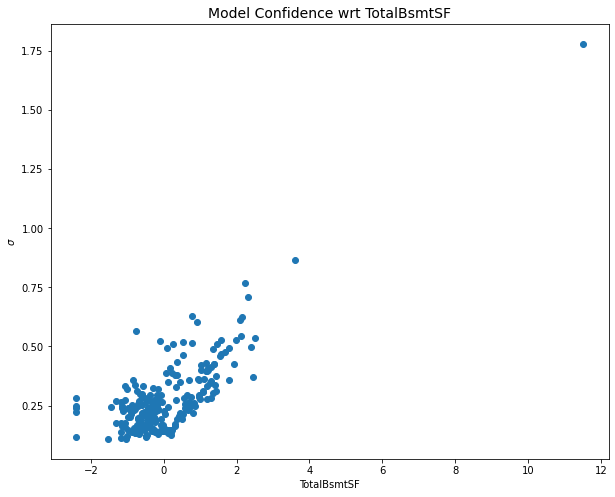

In [ ]:
# Plot model confidence wrt OverallQual
features = np.array(X_test["TotalBsmtSF"])

plt.figure(figsize=(10,8))
plt.title("Model Confidence wrt TotalBsmtSF", fontsize=14)
plt.scatter(features, confidence)
plt.xlabel("TotalBsmtSF")
plt.ylabel("$\sigma$")
plt.show()

#### GrLivArea

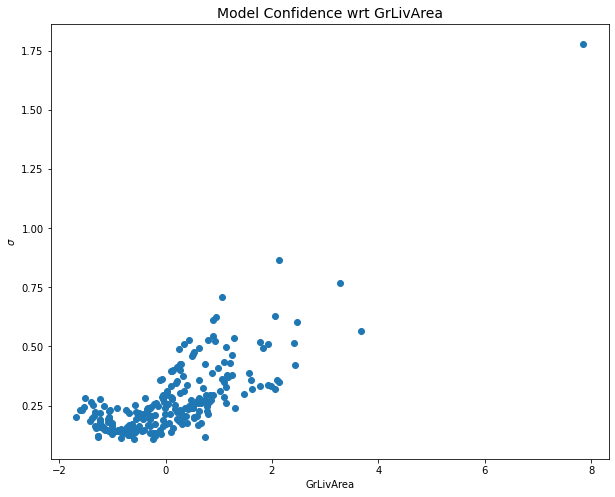

In [ ]:
# Plot model confidence wrt OverallQual
features = np.array(X_test["GrLivArea"])

plt.figure(figsize=(10,8))
plt.title("Model Confidence wrt GrLivArea", fontsize=14)
plt.scatter(features, confidence)
plt.xlabel("GrLivArea")
plt.ylabel("$\sigma$")
plt.show()

For both previous features, it seems like there is a stronger correlation between feature value and model confidence. We could infer that model confidence decreases ($\sigma$ increases) when feature values increase. Let us test these assertions using a simple linear regression model.

#### Correlation Analysis

In [ ]:
import statsmodels.api as sm

In [ ]:
# Build TotalBsmtSF Regression
features = np.array(X_test["TotalBsmtSF"]).reshape(-1,1)

bsmt_model = sm.OLS(features,confidence)
bsmt_fit = bsmt_model.fit()
bsmt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.177
Model:                            OLS   Adj. R-squared (uncentered):              0.174
Method:                 Least Squares   F-statistic:                              55.72
Date:                Wed, 26 Jan 2022   Prob (F-statistic):                    1.27e-12
Time:                        10:47:41   Log-Likelihood:                         -385.91
No. Observations:                 260   AIC:                                      773.8
Df Residuals:                     259   BIC:                                      777.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5925      0.213      7.465      0.000       1.172       2.013
==============================================================================
Omnibus:                      219.205   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7607.702
Skew:                           3.011   Prob(JB):                         0.00
Kurtosis:                      28.807   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression finds positive correlation between TotalBsmtSF value and confidence (1.59). But R-squared value (0.177 is low) and t value (7.47 is high), we aren't able to ensure correlation between the two quantities.

In [ ]:
# Build TotalBsmtSF Regression
features = np.array(X_test["GrLivArea"]).reshape(-1,1)

gr_model = sm.OLS(features,confidence)
gr_fit = gr_model.fit()
gr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.188
Method:                 Least Squares   F-statistic:                              61.17
Date:                Wed, 26 Jan 2022   Prob (F-statistic):                    1.33e-13
Time:                        10:37:57   Log-Likelihood:                         -358.44
No. Observations:                 260   AIC:                                      718.9
Df Residuals:                     259   BIC:                                      722.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5012      0.192      7.821      0.000       1.123       1.879
==============================================================================
Omnibus:                       83.737   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.635
Skew:                           1.272   Prob(JB):                     5.36e-76
Kurtosis:                       8.052   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results are the same as for GrLivArea.